In [20]:
from scipy.optimize import nnls
import numpy as np

In [21]:
def power_law_nl(x, a = 1, b = 2):
    return a * x**b

def power_law_inv(y, a = 1, b = 2):
    return (y / a)**(1/b)

In [22]:
#load data (.mat)
import scipy.io as sio
data = sio.loadmat('../../data/Data_cell_types_small_size.mat')

In [23]:
#extract mean activity per cell type
som = data['sst']
som_act = np.mean(som, axis =0)

pv = data['pv']
pv_act = np.mean(pv, axis =0)

vip = data['vip']
vip_act = np.mean(vip, axis =0)

e = data['pyr']
e_act = np.mean(e, axis =0)

Is = data['contrast']

# SBI

In [24]:
import torch

#from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

### define simulator and prior

In [25]:
#prior
from scipy.stats import expon


prior = [torch.distributions.Exponential(torch.tensor([4.0]))]*24


In [26]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

c:\Users\linau\anaconda3\envs\sbi_env\lib\site-packages\sbi\utils\user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 24 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(


In [27]:
#test simulator
i=0
max_it = 3000
wb = torch.rand((24))
#r =torch.rand(4) 
#I = data['contrast'][0][0]
#A_1 =torch.tensor([r[0], -1* r[1], r[2], -1*r[3], I, 1])
#A_2 = torch.tensor([r[0], -1* r[1], r[2], -1*r[3], 1, 1])
delta_t = 0.05


r = torch.rand(4, 6)  # Initialize r with shape (4, 6)
I_values = data['contrast'][0][:6] /torch.tensor([100]) # Get the 6 different I values

while i < max_it:
    
    for j, I in enumerate(I_values):
        A_1 = torch.tensor([r[0, j], -1 * r[1, j], -1 *r[2, j], -1 * r[3, j], I, 1])
        A_2 = torch.tensor([r[0, j], -1 * r[1, j], -1* r[2, j], -1 * r[3, j], 0, 1])
        
        r_delta = -r[:, j] + power_law_nl(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
        r[:, j] = r[:, j] + delta_t * r_delta
    
    eps = torch.sum(torch.pow(r_delta, 2))
    if eps < 1e-4 or torch.isnan(eps):
        break
    
    i += 1

print(r,i)

tensor([[0.4745, 0.4939, 0.7614, 4.9597, 4.9156,    nan],
        [0.0309, 0.1233, 0.1071, 0.2015, 0.2730,    nan],
        [0.8963, 0.9796, 1.1478, 6.5271, 5.7676,    nan],
        [0.1350, 0.1137, 0.0874, 0.2299, 0.2738,    nan]]) 44


### e and pv

In [28]:

#simulator

def simulator(wb):
    #define inputs
    i=0
    max_it = 2000
    
    delta_t = 0.05
    r =torch.rand(4)
    I =0.12

    while(i <max_it):  
    
        A_1 =torch.tensor([r[0], -1* r[1], -1 *r[2], -1*r[3], I, 1])
        A_2 = torch.tensor([r[0], -1* r[1], -1 *r[2], -1*r[3], 0, 1])
        r_delta = -r + power_law_nl(torch.tensor([A_1@ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]]))
        
        r = r + delta_t * r_delta
        eps = torch.sum(torch.pow(r_delta, 2))
        if eps < 1e-6 or torch.isnan(eps):
            break
        i += 1
    
    return r

    
    



In [29]:
# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)


In [30]:

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [31]:
inference = SNPE(prior=prior)

In [32]:
# theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
# print("theta.shape", theta.shape)
# print("x.shape", x.shape)

In [33]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=30000)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

Running 30000 simulations.:   0%|          | 2/30000 [00:00<1:06:50,  7.48it/s]

Running 30000 simulations.: 100%|██████████| 30000/30000 [42:32<00:00, 11.75it/s]  

theta.shape torch.Size([30000, 24])
x.shape torch.Size([30000, 4])


In [34]:
inference = inference.append_simulations(theta, x)

In [35]:
density_estimator = inference.train()

 Neural network successfully converged after 125 epochs.

In [36]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


Drawing 10000 posterior samples: 10251it [00:10, 936.14it/s]                           


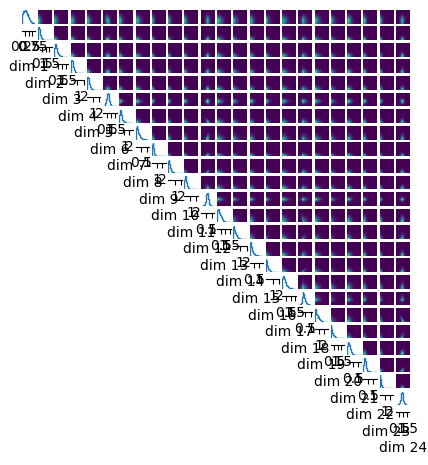

In [44]:
from sbi import analysis as analysis
x_o = torch.tensor([e_act[2], pv_act[2], som_act[2], vip_act[2]])

posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(5, 5)
)

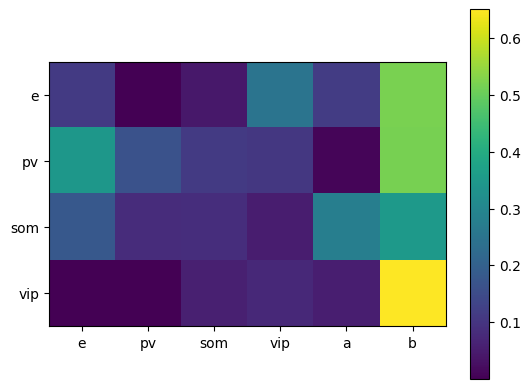

In [45]:
from scipy.stats import mode
from matplotlib import pyplot as plt

weights = mode(posterior_samples.numpy())[0]
weights = weights.reshape(4,6)
plt.imshow(weights)
plt.xticks(np.arange(6), ['e', 'pv', 'som', 'vip', 'a', 'b'])
plt.yticks(np.arange(4), ['e', 'pv', 'som', 'vip'])
plt.colorbar()

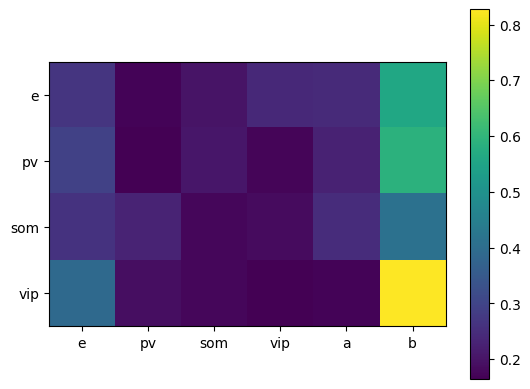

In [65]:
from scipy.stats import mode
from matplotlib import pyplot as plt

weights = posterior_samples.nanmedian(dim=0).values
weights_reshaped = weights.reshape(4,6)
plt.imshow(weights_reshaped)
plt.xticks(np.arange(6), ['e', 'pv', 'som', 'vip', 'a', 'b'])
plt.yticks(np.arange(4), ['e', 'pv', 'som', 'vip'])
plt.colorbar()

In [46]:
samples = posterior.sample((20,), x=x_o)
simulator(samples).median( dim=0)

Drawing 20 posterior samples: 39it [00:00, 72.94it/s]                       


torch.return_types.median(
values=tensor([0.1291, 0.2553, 0.0882, 0.5340]),
indices=tensor([19,  2, 16, 11]))

In [47]:
x_o

tensor([0.2826, 0.2956, 0.1087, 0.5791], dtype=torch.float64)

In [66]:
samples = posterior.sample((100,), x=x_o)
simulations = simulator(samples)

Drawing 100 posterior samples: 113it [00:00, 259.21it/s]                        


In [59]:
simulations.nanmedian(dim=0)

torch.return_types.nanmedian(
values=tensor([0.1843, 0.2735, 0.0782, 0.5579]),
indices=tensor([39, 38, 82, 94]))

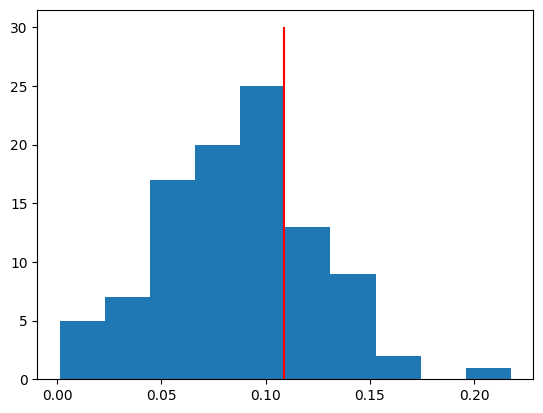

In [79]:
plt.hist(simulations[:,2])
plt.vlines(x_o[2], ymax=30, ymin=0, colors='r')

(array([1646., 1939., 2050., 1808., 1247.,  769.,  334.,  154.,   37.,
          16.]),
 array([6.38353158e-05, 9.93039533e-02, 1.98544070e-01, 2.97784179e-01,
        3.97024304e-01, 4.96264428e-01, 5.95504522e-01, 6.94744647e-01,
        7.93984771e-01, 8.93224895e-01, 9.92465019e-01]),
 <BarContainer object of 10 artists>)

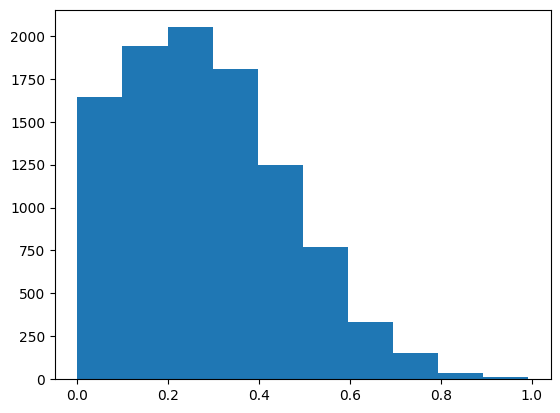

In [78]:
posterior_samples.shape
plt.hist(posterior_samples[:,0])